# Constraint analysis of a single engine piston prop

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

First, we set up a dictionary variable containing elements of the design brief. All of the requirements below refer to ISA standard day conditions (see the documentation for the ``Atmosphere`` class for how to instantiate other atmospheres). The dictionary entry ``cruisethrustfact`` defines the throttle setting expected to be used in cruise (1 = full throttle).

In [2]:
designbrief = {'rwyelevation_m':0, 'groundrun_m':313, # <- Take-off requirements
               'stloadfactor': 1.5, 'turnalt_m': 1000, 'turnspeed_ktas': 100, # <- Turn requirements
               'climbalt_m': 0, 'climbspeed_kias': 101, 'climbrate_fpm': 1398, # <- Climb requirements
               'cruisealt_m': 3048, 'cruisespeed_ktas': 182, 'cruisethrustfact': 1.0, # <- Cruise requirements
               'servceil_m': 6580, 'secclimbspd_kias': 92, # <- Service ceiling requirements
               'vstallclean_kcas': 69} # <- Required clean stall speed

Some constraints may not have to be satisfied at MTOW - ``wfract`` specifies the weight fraction corresponding to each constraint:

In [3]:
wfract = {'turn': 1.0, 'climb': 1.0, 'cruise': 0.853, 'servceil': 1.0}

These fractions, as well as some basic design parameters are specified in the ``designdefinition`` dictionary: aspect ratio, leading edge sweep, sweep of the maximum thickness line of the wing and the engine bypass ratio ('-1' indicates 'piston engine').

In [4]:
designdefinition = {'aspectratio':10.12, 'sweep_le_deg':2, 'sweep_mt_deg':0, 'bpr':-1, 'weightfractions':wfract} 

We next define some design performance estimates, e.g., the propeller efficiencies ($\eta_\mathrm{prop}$) corresponding to the various constraints, drag and lift coefficients and the wheel rolling resistance coefficient:

In [5]:
etap = {'take-off': 0.45, 'climb': 0.8, 'cruise': 0.85, 'turn': 0.85, 'servceil': 0.8}

designperformance = {'CDTO':0.0414, 'CLTO':0.59, 'CLmaxTO':1.69, 'CLmaxclean': 1.45, 'mu_R':0.02, 
                     'CDminclean':0.0254, 'etaprop': etap}

Initial estimate of the take-off weight:

In [6]:
TOW_kg = 1542.0

Define the atmosphere in which the calculations are to be conducted - in this case the International Standard Atmosphere. Other atmospheres available in the ``Atmospheres`` class: off-standard ISAs, MIL-HDBK-310 and bespoke atmospheres.

In [7]:
designatm = at.Atmosphere()

We are now ready to instantiate the aircraft concept object:

In [8]:
concept = ca.AircraftConcept(designbrief, designdefinition, designperformance, designatm)

We define a range of wing loadings for which we want to compute the required power:

In [9]:
wingloadinglist_pa = np.arange(700, 2500, 25)

And the main event: we call the power calculation method, as well as the method for calculating the minimum area dictated by the stall requirement:

In [10]:
preq = concept.powerrequired(wingloadinglist_pa, TOW_kg) 

Smin_m2 = concept.smincleanstall_m2(TOW_kg)

We can now generate a plot of the various constraint curves in the power versus wing area space:

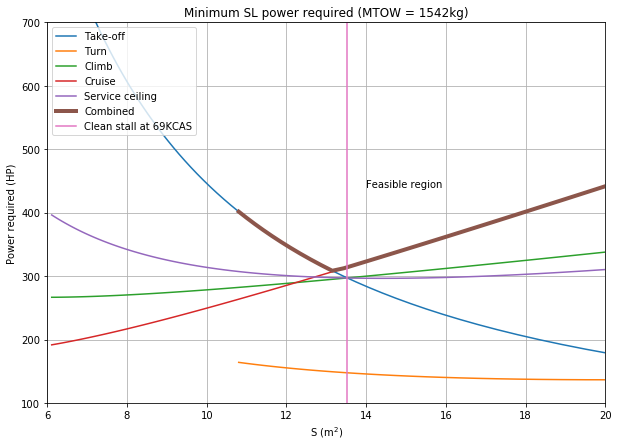

In [11]:
wingarea_m2 = co.kg2n(TOW_kg) / wingloadinglist_pa # x axis

plt.rcParams["figure.figsize"] = [10,7]
plt.plot(wingarea_m2, preq['take-off'],  label = 'Take-off')
plt.plot(wingarea_m2, preq['turn'], label = 'Turn')
plt.plot(wingarea_m2, preq['climb'], label = 'Climb')
plt.plot(wingarea_m2, preq['cruise'], label = 'Cruise')
plt.plot(wingarea_m2, preq['servceil'], label = 'Service ceiling')
combplot = plt.plot(wingarea_m2, preq['combined'], label = 'Combined')
plt.setp(combplot, linewidth=4)
stall_label = 'Clean stall at ' + str(designbrief['vstallclean_kcas']) + 'KCAS'
plt.plot([Smin_m2, Smin_m2], [0, 1500], label = stall_label)
legend = plt.legend(loc='upper left')
plt.ylabel("Power required (HP)")
plt.xlabel("S (m$^2$)")
plt.title("Minimum SL power required (MTOW = " + str(round(TOW_kg)) + "kg)")
plt.xlim(6, 20)
plt.ylim(100, 700)
plt.grid(True)
plt.text(14, 440, 'Feasible region')
plt.show()